

# Capstone Project Segmenting and Clustering Neighborhoods in Toronto City

----
## Table of Contents

* [Intoduction: Description of the Problem](#introduction)
* [Parsing and Cleaning Data](#parsing)
* [Explore Neighborhoods in Toronto ](#explore)
* [Analyze Each Neighborhood](#analyze)
* [Cluster Neighborhoods](#clustering)
* [Examine Clusters](#examine) 
* [Conclusion](#conclusion)

---
## Intoduction: Description of the Problem <a name="introduction"></a>

Today in modern city there are hundreds of venues and at each of its decade’s restaurants, shops, houses etc. For city government and businessman, who decide open new spa or park, or for citizens, who want to buy new home, very important know what is difference between city areas, which often unequal to districts borders. 

So, needs some clusterisation, that dividing city on clusters based on most using places in that area. That is the main purpose of this project.

---
Import libraries

In [2]:
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
import urllib

import geocoder 
from geopy.geocoders import Nominatim

import folium 

import requests 
import json 
from pandas.io.json import json_normalize 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

%matplotlib inline
print('Libraries imported.')

Libraries imported.


---
## Parsing and Cleaning Data <a name="parsing"></a>

In this project data was scraped from [wikipedia page](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) using BeautifulSoup library (for more information [link here](https://beautiful-soup-4.readthedocs.io/en/latest/#))."

In [5]:
page = urllib.request.urlopen('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').read()
soup = BeautifulSoup(page)

In [6]:
table = soup.find_all('table')
df = pd.read_html(str(table))[0]
df.head()

Postal Code           Borough              Neighbourhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront

Drop 'Not assigned' objects.

In [7]:
df = df.loc[(df['Borough']!='Not assigned') & (df['Neighbourhood']!='Not assigned')]
df.reset_index(drop=True,inplace=True)

In [8]:
df.head(10)

Postal Code           Borough                                Neighbourhood
0         M3A        North York                                    Parkwoods
1         M4A        North York                             Victoria Village
2         M5A  Downtown Toronto                    Regent Park, Harbourfront
3         M6A        North York             Lawrence Manor, Lawrence Heights
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government
5         M9A         Etobicoke      Islington Avenue, Humber Valley Village
6         M1B       Scarborough                               Malvern, Rouge
7         M3B        North York                                    Don Mills
8         M4B         East York              Parkview Hill, Woodbine Gardens
9         M5B  Downtown Toronto                     Garden District, Ryerson

In 'Neighbourhood' columns for one borough there are more then one neighbourhoods, so let's change DataFrame with only one neighbourhoods in row.    

In [9]:
lendf = df.shape[0]
for i in range(lendf):
    lst = df['Neighbourhood'][i].split(sep = ',')
    pc = df['Postal Code'][i]
    b = df['Borough'][i]
    
    for l in range(len(lst)):
        line = pd.DataFrame({'Postal Code': pc,'Borough': b,'Neighbourhood': lst[l]},index=[0])
        df = df.append(line,ignore_index=True)
        
df = df.loc[103:,:]
df.reset_index(drop=True,inplace=True)

In [10]:
df

Postal Code           Borough              Neighbourhood
0           M3A        North York                  Parkwoods
1           M4A        North York           Victoria Village
2           M5A  Downtown Toronto                Regent Park
3           M5A  Downtown Toronto               Harbourfront
4           M6A        North York             Lawrence Manor
..          ...               ...                        ...
212         M8Z         Etobicoke                  Mimico NW
213         M8Z         Etobicoke         The Queensway West
214         M8Z         Etobicoke             South of Bloor
215         M8Z         Etobicoke   Kingsway Park South West
216         M8Z         Etobicoke      Royal York South West

[217 rows x 3 columns]

Now, get the coordinates for every neighbourhood using Nominatim search engine with Forsquare agent.

In [ ]:
ll = pd.DataFrame(columns=['Latitude','Longitude'])
for post in df['Neighbourhood'].values:
    geolocator = Nominatim(user_agent="foursquare_agent")
    
    g = geolocator.geocode('{}, Toronto, Canada'.format(post))
    #exeptions if response is Null object
    if (g is None):
        latitude = float('nan')
        longitude = float('nan')
    else:
        latitude = g.latitude
        longitude = g.longitude
    
    ll = ll.append({'Latitude': latitude,'Longitude': longitude},ignore_index=True)

ll.shape

Join both datasets

In [164]:
df = df.join(ll)
df.head(10)

Postal Code           Borough                   Neighbourhood   Latitude  \
0         M3A        North York                       Parkwoods  43.761124   
1         M4A        North York                Victoria Village  43.732658   
2         M5A  Downtown Toronto                     Regent Park  43.660706   
3         M5A  Downtown Toronto                    Harbourfront  43.640080   
4         M6A        North York                  Lawrence Manor  43.722079   
5         M6A        North York                Lawrence Heights  43.722778   
6         M7A  Downtown Toronto                    Queen's Park  43.659659   
7         M7A  Downtown Toronto   Ontario Provincial Government        NaN   
8         M9A         Etobicoke                Islington Avenue  43.620087   
9         M9A         Etobicoke           Humber Valley Village  43.666472   

   Longitude  
0 -79.324059  
1 -79.311189  
2 -79.360457  
3 -79.380150  
4 -79.437507  
5 -79.450933  
6 -79.390340  
7        NaN  
8 -79.512783  
9 -79.524314

Dropping NaN values

In [16]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

#### Create a map of Toronto with neighborhoods using Geopy and Folium library.

In [65]:
with open('Data/toronto.txt') as json_data:
    toronto_data = json.load(json_data)    

In [66]:
geolocator = Nominatim(user_agent="foursquare_agent")    
g = geolocator.geocode('Toronto, Ontario')
latitude = g.latitude
longitude = g.longitude

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

folium.GeoJson(toronto_data,name='geojson').add_to(map_toronto)

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [7]:
df.head()

Postal Code           Borough     Neighbourhood   Latitude  Longitude
0         M3A        North York         Parkwoods  43.761124 -79.324059
1         M4A        North York  Victoria Village  43.732658 -79.311189
2         M5A  Downtown Toronto       Regent Park  43.660706 -79.360457
3         M5A  Downtown Toronto      Harbourfront  43.640080 -79.380150
4         M6A        North York    Lawrence Manor  43.722079 -79.437507

Now, let's calculate maximum distance between closest points.

In [43]:
s = np.array([])
for n in df.index.values:
    center = np.array([df['Latitude'].values[n],df['Longitude'].values[n]])
    dflat = df['Latitude'].loc[df['Latitude']!=df['Latitude'].values[n]].values
    dflong = df['Longitude'].loc[df['Longitude']!=df['Longitude'].values[n]].values
    
    compare = np.sqrt(np.square(dflat - center[0]) + np.square(dflong - center[1]))
    s = np.append(s,min(compare))
    
print(max(s))

0.03558069123371447


Cell above get distance in decimal coordinates, so convert it in meters. As known, that Toronto have 40 km long and in coordinates is about 0.4787. 

In [49]:
print('Target radius:',round((max(s)/0.47872367966822743)*40),'km')

Target radius: 3 km


---
## Explore Neighborhoods in Toronto <a name="explore"></a>

Define Foursquare Credentials and Version

In [50]:
CLIENT_ID = 'DEI3012WOENGCUBYZR1EAHJ0F3G4LLNWKN3K10Q20RHNXXE3' 
CLIENT_SECRET = 'SQXWKQESPDUOJE0H4TGUN1VJOWE2IBP4VNDTIYVFUIHREMDX'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DEI3012WOENGCUBYZR1EAHJ0F3G4LLNWKN3K10Q20RHNXXE3
CLIENT_SECRET:SQXWKQESPDUOJE0H4TGUN1VJOWE2IBP4VNDTIYVFUIHREMDX


In [62]:
centoronto_data = df
centoronto_data

Postal Code           Borough           Neighbourhood   Latitude  \
0           M3A        North York               Parkwoods  43.761124   
1           M4A        North York        Victoria Village  43.732658   
2           M5A  Downtown Toronto             Regent Park  43.660706   
3           M5A  Downtown Toronto            Harbourfront  43.640080   
4           M6A        North York          Lawrence Manor  43.722079   
..          ...               ...                     ...        ...   
193         M8Y         Etobicoke   Royal York South East  43.648183   
194         M8Z         Etobicoke               Mimico NW  43.616677   
195         M8Z         Etobicoke      The Queensway West  43.623618   
196         M8Z         Etobicoke          South of Bloor  43.670489   
197         M8Z         Etobicoke   Royal York South West  43.648183   

     Longitude  
0   -79.324059  
1   -79.311189  
2   -79.360457  
3   -79.380150  
4   -79.437507  
..         ...  
193 -79.511296  
194 -79.496805  
195 -79.514764  
196 -79.386465  
197 -79.511296  

[198 rows x 5 columns]

Create a function to get the top 100 venues that are in Toronto within a radius as parameter.

In [52]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [53]:
centoronto_venues = getNearbyVenues(centoronto_data['Neighbourhood'],
                                    centoronto_data['Latitude'],centoronto_data['Longitude'],1500)

Parkwoods
Victoria Village
Regent Park
 Harbourfront
Lawrence Manor
 Lawrence Heights
Queen's Park
Islington Avenue
 Humber Valley Village
Malvern
 Rouge
Don Mills
 Woodbine Gardens
Garden District
 Ryerson
Glencairn
West Deane Park
 Princess Gardens
 Islington
 Cloverdale
Rouge Hill
 Port Union
 Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate
 Bloordale Gardens
 Old Burnhamthorpe
 Markland Wood
Guildwood
 Morningside
 West Hill
The Beaches
Berczy Park
Woburn
Leaside
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor
 Wilson Heights
 Downsview North
Thorncliffe Park
Richmond
 Adelaide
 King
Dufferin
 Dovercourt Village
Scarborough Village
Fairview
 Henry Farm
 Oriole
Northwood Park
 York University
East Toronto
 Broadview North (Old East York)
Harbourfront East
 Union Station
 Toronto Islands
Little Portugal
 Trinity
Kennedy Park
 Ionview
 East Birchmount Park
Bayview Village
Downsview
The Danforth West
 Riverdale
Toronto Dominion Centre
 Design Ex

Check the results

In [99]:
centoronto_venues = pd.read_csv('Data/Venues1500.csv')

In [76]:
print(centoronto_venues.shape)
centoronto_venues.head()

(13521, 8)


Unnamed: 0 Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0           0     Parkwoods               43.761124               -79.324059   
1           1     Parkwoods               43.761124               -79.324059   
2           2     Parkwoods               43.761124               -79.324059   
3           3     Parkwoods               43.761124               -79.324059   
4           4     Parkwoods               43.761124               -79.324059   

             Venue  Venue Latitude  Venue Longitude        Venue Category  
0  Allwyn's Bakery       43.759840       -79.324719  Caribbean Restaurant  
1      Tim Hortons       43.760668       -79.326368                  Café  
2              A&W       43.760643       -79.326865  Fast Food Restaurant  
3             LCBO       43.757774       -79.314257          Liquor Store  
4        Dollarama       43.758135       -79.310672        Discount Store

Plot how many venues were returned for each neighborhood.

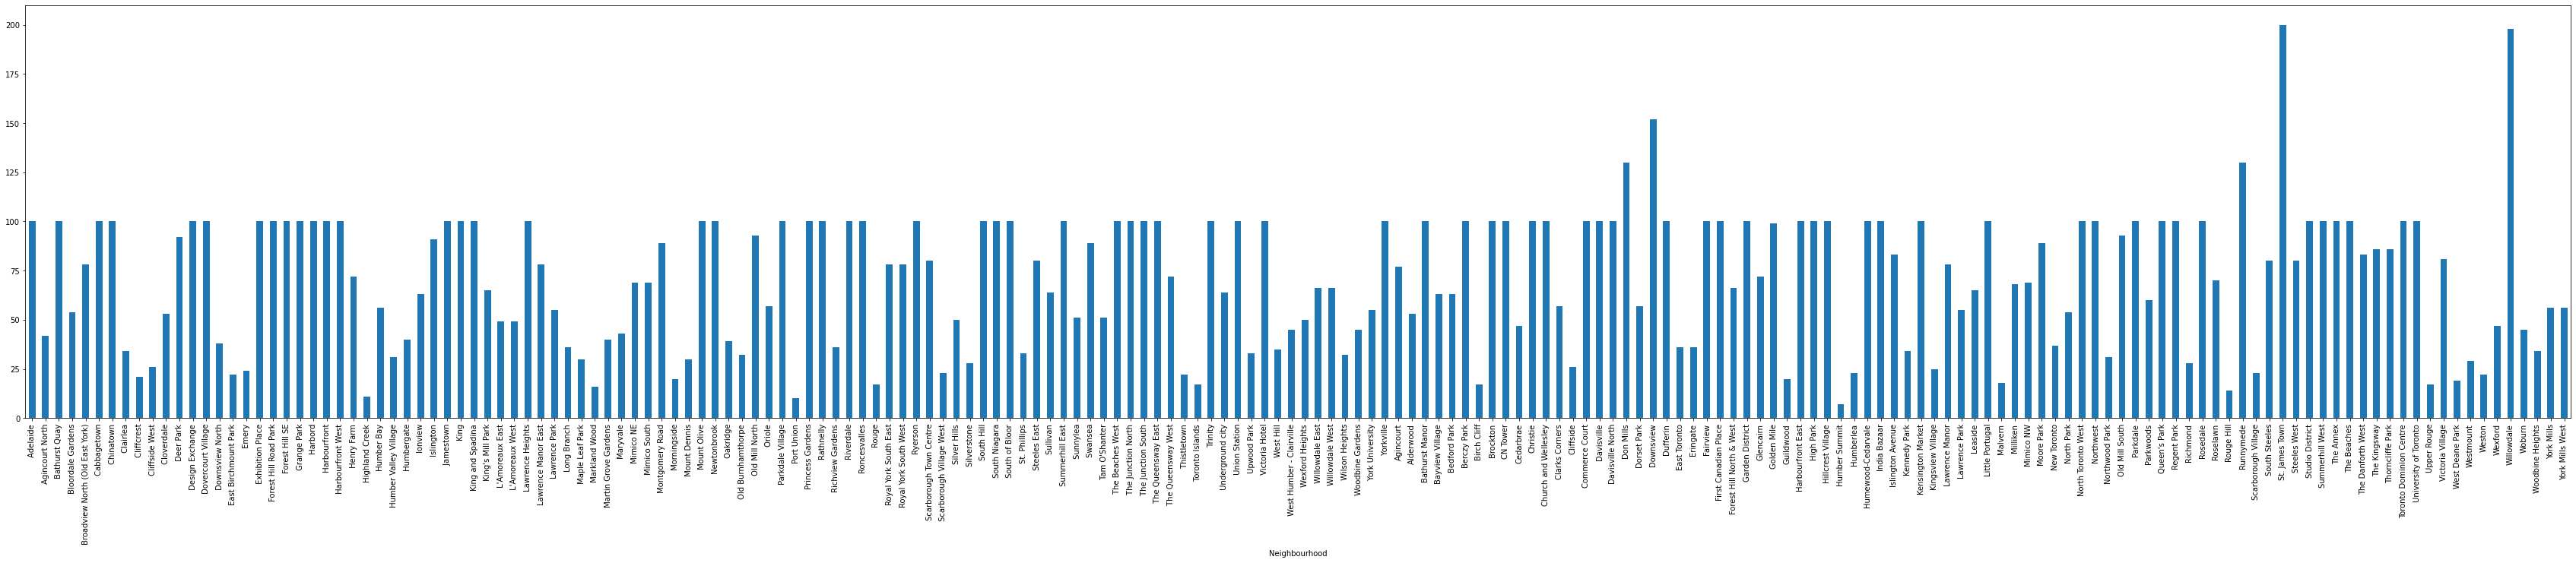

In [56]:
p = centoronto_venues.groupby('Neighbourhood').count()

fig = plt.figure() 

p['Venue'].plot.bar(figsize=(60,10))

plt.show()

---
## Analyze Each Neighborhood <a name="analyze"></a>

Encoding venues category for each neighborhoods and add this column to first position.

In [100]:
centoronto_onehot = pd.get_dummies(centoronto_venues[['Venue Category']], prefix="", prefix_sep="")
centoronto_onehot['Neighbourhood'] = centoronto_venues['Neighbourhood'] 
fixed_columns = [centoronto_onehot.columns[-1]] + list(centoronto_onehot.columns[:-1])
centoronto_onehot = centoronto_onehot[fixed_columns]

centoronto_onehot.head()

Neighbourhood  Accessories Store  Afghan Restaurant  Airport  \
0     Parkwoods                  0                  0        0   
1     Parkwoods                  0                  0        0   
2     Parkwoods                  0                  0        0   
3     Parkwoods                  0                  0        0   
4     Parkwoods                  0                  0        0   

   American Restaurant  Amphitheater  Animal Shelter  Antique Shop  Aquarium  \
0                    0             0               0             0         0   
1                    0             0               0             0         0   
2                    0             0               0             0         0   
3                    0             0               0             0         0   
4                    0             0               0             0         0   

   Arcade  ...  Volleyball Court  Warehouse Store  Whisky Bar  Wine Bar  \
0       0  ...                 0                0           0         0   
1       0  ...                 0                0           0         0   
2       0  ...                 0                0           0         0   
3       0  ...                 0                0           0         0   
4       0  ...                 0                0           0         0   

   Wine Shop  Wings Joint  Women's Store  Xinjiang Restaurant  Yoga Studio  \
0          0            0              0                    0            0   
1          0            0              0                    0            0   
2          0            0              0                    0            0   
3          0            0              0                    0            0   
4          0            0              0                    0            0   

   Zoo  
0    0  
1    0  
2    0  
3    0  
4    0  

[5 rows x 358 columns]

Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [101]:
centoronto_grouped = centoronto_onehot.groupby('Neighbourhood').mean().reset_index()
centoronto_grouped.shape

(190, 358)

Further, needs define for each neighborhood along with the top 10 most common venues.

For this, first, write a function to sort the venues in descending order.

In [59]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now create the new dataframe with top 10 venues for each neighborhood.

In [102]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = centoronto_grouped['Neighbourhood']

for ind in np.arange(centoronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(centoronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

Neighbourhood 1st Most Common Venue  \
0                          Adelaide           Coffee Shop   
1                   Agincourt North     Indian Restaurant   
2                     Bathurst Quay                  Park   
3                 Bloordale Gardens           Coffee Shop   
4   Broadview North (Old East York)      Greek Restaurant   

  2nd Most Common Venue 3rd Most Common Venue  4th Most Common Venue  \
0            Restaurant                  Café                  Hotel   
1           Coffee Shop           Pizza Place  Vietnamese Restaurant   
2           Coffee Shop                   Gym                   Café   
3        Sandwich Place            Beer Store                   Bank   
4                  Park                  Café     Italian Restaurant   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0              Beer Bar   Japanese Restaurant             Gastropub   
1        Sandwich Place    Chinese Restaurant                  Bank   
2            Restaurant           Yoga Studio    Italian Restaurant   
3                   Gym           Pizza Place          Liquor Store   
4                   Pub                Bakery           Coffee Shop   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0       Thai Restaurant           Pizza Place                  Plaza  
1                  Park              Pharmacy        Bubble Tea Shop  
2                Bakery    Seafood Restaurant                Dog Run  
3        Clothing Store              Pharmacy      Convenience Store  
4           Pizza Place          Burger Joint            Flower Shop

---
## Cluster Neighborhoods <a name="clustering"></a>

Run _k_-means to cluster the neighborhood into different clusters.

In [82]:
from sklearn.model_selection import GridSearchCV

In [103]:
centoronto_grouped_clustering = centoronto_grouped.drop('Neighbourhood', 1)

parameters = [{'n_clusters': [4,5,6,7],'init': ['random'],'random_state':[5], 'algorithm': ['elkan']}]
kmeans = KMeans()
Grid = GridSearchCV(kmeans,parameters)
Grid.fit(centoronto_grouped_clustering)

GridSearchCV(estimator=KMeans(),
             param_grid=[{'algorithm': ['elkan'], 'init': ['random'],
                          'n_clusters': [4, 5, 6, 7], 'random_state': [5]}])

In [104]:
BestGrid = Grid.best_estimator_
kclusters = len(np.unique(BestGrid.labels_))
print(BestGrid)

KMeans(algorithm='elkan', init='random', n_clusters=7, random_state=5)


After clustering, create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [105]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', BestGrid.labels_)
centoronto_merged = centoronto_data
centoronto_merged = centoronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood',how='right')

centoronto_merged.head()

Postal Code           Borough                     Neighbourhood  \
46          M5H  Downtown Toronto                          Adelaide   
150         M1V       Scarborough                   Agincourt North   
161         M5V  Downtown Toronto                     Bathurst Quay   
28          M9C         Etobicoke                 Bloordale Gardens   
57          M4J         East York   Broadview North (Old East York)   

      Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
46   43.650298 -79.380477               2           Coffee Shop   
150  43.808038 -79.266439               3     Indian Restaurant   
161  43.635791 -79.398329               2                  Park   
28   43.635317 -79.563674               3           Coffee Shop   
57   43.683924 -79.356964               6      Greek Restaurant   

    2nd Most Common Venue 3rd Most Common Venue  4th Most Common Venue  \
46             Restaurant                  Café                  Hotel   
150           Coffee Shop           Pizza Place  Vietnamese Restaurant   
161           Coffee Shop                   Gym                   Café   
28         Sandwich Place            Beer Store                   Bank   
57                   Park                  Café     Italian Restaurant   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
46               Beer Bar   Japanese Restaurant             Gastropub   
150        Sandwich Place    Chinese Restaurant                  Bank   
161            Restaurant           Yoga Studio    Italian Restaurant   
28                    Gym           Pizza Place          Liquor Store   
57                    Pub                Bakery           Coffee Shop   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
46        Thai Restaurant           Pizza Place                  Plaza  
150                  Park              Pharmacy        Bubble Tea Shop  
161                Bakery    Seafood Restaurant                Dog Run  
28         Clothing Store              Pharmacy      Convenience Store  
57            Pizza Place          Burger Joint            Flower Shop

And, finally, visualize the resulting clusters.

In [106]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

folium.GeoJson(toronto_data,name='geojson').add_to(map_clusters)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(centoronto_merged['Latitude'], centoronto_merged['Longitude'],
                                  centoronto_merged['Neighbourhood'], centoronto_merged['Cluster Labels']):
    
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [115]:
map_clusters.save('Data/clusters1500.html')

---
## Examine Clusters <a name="examine"></a>

Now, examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, possible assign a name to each cluster.


#### Cluster 1

In [107]:
centoronto_merged.loc[centoronto_merged['Cluster Labels'] == 0, centoronto_merged.columns[[1] + list(range(5, centoronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
90        Scarborough               0       Harbor / Marina   
102       Scarborough               0                  Park   
98               York               0           Coffee Shop   
21        Scarborough               0                  Park   
10        Scarborough               0                  Park   
60   Downtown Toronto               0       Harbor / Marina   
101       Scarborough               0                  Park   
89        Scarborough               0                  Park   
27          Etobicoke               0                  Park   
31        Scarborough               0           Pizza Place   
9         Scarborough               0                  Park   
54         North York               0  Fast Food Restaurant   
20        Scarborough               0                  Park   
178       Scarborough               0                  Park   
16          Etobicoke               0                  Park   
24          East York               0           Pizza Place   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
90            Pizza Place  Fast Food Restaurant    Chinese Restaurant   
102           Coffee Shop                   Pub       Harbor / Marina   
98                   Park      Asian Restaurant     Convenience Store   
21         Sandwich Place     Convenience Store             Pet Store   
10                  Trail           Gas Station           Pizza Place   
60                   Park            Lighthouse           Pizza Place   
101           Pizza Place    Chinese Restaurant                  Café   
89            Coffee Shop                   Pub       Harbor / Marina   
27         Sandwich Place           Pizza Place        Baseball Field   
31          Grocery Store                  Park         Train Station   
9    Fast Food Restaurant         Grocery Store           Pizza Place   
54                   Park         Grocery Store           Coffee Shop   
20            Pizza Place           Supermarket        Sandwich Place   
178                 Trail           Gas Station           Pizza Place   
16      Convenience Store           Pizza Place    Athletics & Sports   
24                   Park          Skating Rink           Coffee Shop   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
90       Asian Restaurant         Grocery Store             Gift Shop   
102        Breakfast Spot         Grocery Store    Seafood Restaurant   
98            Gas Station          Tennis Court           Golf Course   
21   Fast Food Restaurant           Pizza Place           Coffee Shop   
10               Pharmacy                  Bank  Gym / Fitness Center   
60                Dog Run             BBQ Joint         Boat or Ferry   
101           Golf Course                   Gym                 Diner   
89         Breakfast Spot         Grocery Store    Seafood Restaurant   
27           Intersection     Convenience Store                   Pub   
31                    Pub              Bus Line           Golf Course   
9                Pharmacy       Bubble Tea Shop          Skating Rink   
54            Gas Station           Pizza Place        Discount Store   
20          Train Station              Pharmacy  Fast Food Restaurant   
178              Pharmacy                  Bank  Gym / Fitness Center   
16         Sandwich Place           Coffee Shop              Pharmacy   
24         Sandwich Place  Fast Food Restaurant  Gym / Fitness Center   

    8th Most Common Venue 9th Most Common Venue  10th Most Common Venue  
90           Liquor Store                  Park          Hardware Store  
102        Hardware Store      Sushi Restaurant          Sandwich Place  
98             Beer Store           Supermarket  Thrift / Vintage Store  
21             Beer Store         Train Station                     Zoo  
10             Campground                Garden          Discount Store  
60            

According map and cluster description this cluster represents areas,which located on coast or near harbor and rivers. 

So, marked this cluster as **'Coasts Areas'**.

#### Cluster 2

In [108]:
centoronto_merged.loc[centoronto_merged['Cluster Labels'] == 1, centoronto_merged.columns[[1] + list(range(5, centoronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
152  Scarborough               1    Chinese Restaurant           Coffee Shop   
172  Scarborough               1    Chinese Restaurant           Coffee Shop   
151  Scarborough               1    Chinese Restaurant       Bubble Tea Shop   
135  Scarborough               1    Chinese Restaurant         Shopping Mall   
141  Scarborough               1    Chinese Restaurant           Coffee Shop   
149  Scarborough               1    Chinese Restaurant                  Park   
165    Etobicoke               1    Chinese Restaurant       Bubble Tea Shop   
171  Scarborough               1    Chinese Restaurant       Bubble Tea Shop   

    3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  \
152  Fast Food Restaurant  Vietnamese Restaurant              Pharmacy   
172  Fast Food Restaurant  Vietnamese Restaurant              Pharmacy   
151                Bakery    Japanese Restaurant              Tea Room   
135  Cantonese Restaurant                   Bank  Fast Food Restaurant   
141       Bubble Tea Shop  Vietnamese Restaurant          Dessert Shop   
149       Bubble Tea Shop                 Bakery           Pizza Place   
165                Bakery    Japanese Restaurant              Tea Room   
171                Bakery    Japanese Restaurant              Tea Room   

     6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
152                   Bank         Grocery Store    Athletics & Sports   
172                   Bank         Grocery Store    Athletics & Sports   
151  Vietnamese Restaurant     Korean Restaurant                  Park   
135         Sandwich Place             Bookstore   Filipino Restaurant   
141              BBQ Joint                Bakery              Pharmacy   
149           Noodle House   Japanese Restaurant                   Gym   
165  Vietnamese Restaurant     Korean Restaurant                  Park   
171  Vietnamese Restaurant     Korean Restaurant                  Park   

    9th Most Common Venue 10th Most Common Venue  
152           Pizza Place           Intersection  
172           Pizza Place           Intersection  
151           Gas Station                   Bank  
135           Pizza Place            Coffee Shop  
141                  Park            Gas Station  
149                  Bank      Korean Restaurant  
165           Gas Station                   Bank  
171           Gas Station                   Bank

According the 1st common venues, obvious, it's **'Chinatown'**

#### Cluster 3

In [109]:
centoronto_merged.loc[centoronto_merged['Cluster Labels'] == 2, centoronto_merged.columns[[1] + list(range(5, centoronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
46   Downtown Toronto               2           Coffee Shop   
161  Downtown Toronto               2                  Park   
180  Downtown Toronto               2           Coffee Shop   
71   Downtown Toronto               2                  Café   
148  Downtown Toronto               2           Coffee Shop   
3    Downtown Toronto               2           Coffee Shop   
160  Downtown Toronto               2           Coffee Shop   
168         Etobicoke               2           Coffee Shop   
47   Downtown Toronto               2           Coffee Shop   
169         Etobicoke               2           Coffee Shop   
17          Etobicoke               2           Coffee Shop   
154   Central Toronto               2    Italian Restaurant   
14   Downtown Toronto               2           Coffee Shop   
155   Central Toronto               2    Italian Restaurant   
196         Etobicoke               2           Coffee Shop   
82       East Toronto               2                   Pub   
62       West Toronto               2           Coffee Shop   
59   Downtown Toronto               2                  Café   
84   Downtown Toronto               2           Coffee Shop   
104        North York               2   Japanese Restaurant   
124        North York               2   Japanese Restaurant   
128   Central Toronto               2           Coffee Shop   
35   Downtown Toronto               2           Coffee Shop   
158  Downtown Toronto               2           Coffee Shop   
186  Downtown Toronto               2           Coffee Shop   
83   Downtown Toronto               2                  Café   
51         North York               2           Coffee Shop   
181  Downtown Toronto               2           Coffee Shop   
13   Downtown Toronto               2           Coffee Shop   
58   Downtown Toronto               2           Coffee Shop   
6    Downtown Toronto               2           Coffee Shop   
173  Downtown Toronto               2    Italian Restaurant   
25   Downtown Toronto               2           Coffee Shop   
179  Downtown Toronto               2           Coffee Shop   
95       East Toronto               2           Coffee Shop   
34       East Toronto               2                   Pub   
70   Downtown Toronto               2           Coffee Shop   
92         North York               2   Japanese Restaurant   
103        North York               2   Japanese Restaurant   
123        North York               2   Japanese Restaurant   

    2nd Most Common Venue 3rd Most Common Venue  \
46             Restaurant                  Café   
161           Coffee Shop                   Gym   
180                  Park                  Café   
71             Restaurant           Coffee Shop   
148                  Café            Restaurant   
3                    Café                 Hotel   
160                  Café                 Hotel   
168            Restaurant             Gastropub   
47                   Café            Restaurant   
169            Restaurant             Gastropub   
17                   Café                 Hotel   
154           Coffee Shop                   Spa   
14              Gastropub   Japanese Restaurant   
155           Coffee Shop        Ice Cream Shop   
196    Italian Restaurant            Restaurant   
82                  Beach           Coffee Shop   
62                   Café            Restaurant   
59                  Hotel           Coffee Shop   
84                   Park                  Café   
104           Pizza Place         Grocery Store   
124           Pizza Place         Grocery Store   
128    Italian Restaurant            Restaurant   
35                   Café            Restaurant   
158                 Hotel                  Café   
186   Japanese Restaurant             Gastropub   
83            Coffee Shop                 Hotel   
51             Restaurant             Gastropub   
18

In this cluster the most common the coffee shops, cafes, pubs and points are located in center of Toronto, so this is **'City Center'**.

#### Cluster 4

In [110]:
centoronto_merged.loc[centoronto_merged['Cluster Labels'] == 3, centoronto_merged.columns[[1] + list(range(5, centoronto_merged.shape[1]))]]

Borough  Cluster Labels      1st Most Common Venue  \
150  Scarborough               3          Indian Restaurant   
28     Etobicoke               3                Coffee Shop   
76   Scarborough               3                     Bakery   
19     Etobicoke               3                Coffee Shop   
43    North York               3             Sandwich Place   
..           ...             ...                        ...   
1     North York               3                Coffee Shop   
120    Etobicoke               3                Pizza Place   
110         York               3                Coffee Shop   
121  Scarborough               3  Middle Eastern Restaurant   
36   Scarborough               3       Fast Food Restaurant   

    2nd Most Common Venue      3rd Most Common Venue  4th Most Common Venue  \
150           Coffee Shop                Pizza Place  Vietnamese Restaurant   
28         Sandwich Place                 Beer Store                   Bank   
76            Pizza Place                Coffee Shop                   Bank   
19          Grocery Store             Sandwich Place                   Bank   
43   Gym / Fitness Center                Flea Market     Athletics & Sports   
..                    ...                        ...                    ...   
1    Fast Food Restaurant  Middle Eastern Restaurant          Grocery Store   
120           Coffee Shop              Train Station                  Plaza   
110        Sandwich Place                Pizza Place          Train Station   
121          Burger Joint                Coffee Shop                   Park   
36            Pizza Place                Coffee Shop         Sandwich Place   

     5th Most Common Venue 6th Most Common Venue     7th Most Common Venue  \
150         Sandwich Place    Chinese Restaurant                      Bank   
28                     Gym           Pizza Place              Liquor Store   
76                Bus Line  Fast Food Restaurant              Intersection   
19   Vietnamese Restaurant  Fast Food Restaurant          Department Store   
43            Skating Rink           Coffee Shop                Playground   
..                     ...                   ...                       ...   
1              Pizza Place                   Gym        Chinese Restaurant   
120                   Park        Sandwich Place            Ice Cream Shop   
110           Skating Rink           Gas Station             Grocery Store   
121             Hookah Bar           Pizza Place  Mediterranean Restaurant   
36        Department Store        Discount Store                      Park   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
150                  Park              Pharmacy        Bubble Tea Shop  
28         Clothing Store              Pharmacy      Convenience Store  
76             Restaurant                  Park         Sandwich Place  
19               Pharmacy            Beer Store    Sporting Goods Shop  
43            Escape Room               Theater           Climbing Gym  
..                    ...                   ...                    ...  
1            Intersection            Shoe Store    Rental Car Location  
120           Flea Market   Fried Chicken Joint                   Café  
110                 Diner    Chinese Restaurant    Fried Chicken Joint  
121    Chinese Restaurant     Korean Restaurant    Rental Car Location  
36                  Diner         Grocery Store       Czech Restaurant  

[68 rows x 12 columns]

According number and location of this cluster, it's **'Low Cost Residential Areas'**.

#### Cluster 5

In [111]:
centoronto_merged.loc[centoronto_merged['Cluster Labels'] == 4, centoronto_merged.columns[[1] + list(range(5, centoronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
157  Central Toronto               4                  Park   
117  Central Toronto               4    Italian Restaurant   
156  Central Toronto               4           Coffee Shop   
22       Scarborough               4          Burger Joint   
190        Etobicoke               4           Coffee Shop   
167        Etobicoke               4                  Park   
18         Etobicoke               4           Coffee Shop   
188        Etobicoke               4           Coffee Shop   
126  Central Toronto               4      Sushi Restaurant   
191        Etobicoke               4           Coffee Shop   
164        Etobicoke               4           Coffee Shop   
184        Etobicoke               4           Coffee Shop   
185        Etobicoke               4                  Café   
193        Etobicoke               4           Coffee Shop   
197        Etobicoke               4           Coffee Shop   
145  Central Toronto               4    Italian Restaurant   
189        Etobicoke               4                  Park   
140     West Toronto               4                  Park   
195        Etobicoke               4            Restaurant   
96        North York               4           Coffee Shop   
136  Central Toronto               4    Italian Restaurant   
115  Central Toronto               4    Italian Restaurant   
56         East York               4           Coffee Shop   
116  Central Toronto               4           Pizza Place   
40        North York               4    Italian Restaurant   
26              York               4                  Bank   
7          Etobicoke               4            Restaurant   
106  Central Toronto               4      Sushi Restaurant   
37         East York               4     Indian Restaurant   
194        Etobicoke               4           Coffee Shop   
144  Central Toronto               4                  Park   
163        Etobicoke               4          Skating Rink   
187        Etobicoke               4                  Café   
153  Central Toronto               4    Italian Restaurant   
183        Etobicoke               4           Coffee Shop   
78        North York               4           Coffee Shop   
114       North York               4           Coffee Shop   

    2nd Most Common Venue 3rd Most Common Venue   4th Most Common Venue  \
157    Italian Restaurant      Sushi Restaurant                    Café   
117      Sushi Restaurant           Coffee Shop                    Café   
156           Pizza Place                  Bank      Italian Restaurant   
22            Coffee Shop    Athletics & Sports      Italian Restaurant   
190    Italian Restaurant      Sushi Restaurant                    Bank   
167    Italian Restaurant                  Bank       Indian Restaurant   
18     Italian Restaurant      Sushi Restaurant                    Bank   
188                Bakery                  Park                     Pub   
126    Italian Restaurant           Coffee Shop                  Bakery   
191                  Park                  Bank              Restaurant   
164                  Park                  Bank              Restaurant   
184    Italian Restaurant      Sushi Restaurant                    Bank   
185           Coffee Shop           Pizza Place      Italian Restaurant   
193    Italian Restaurant      Sushi Restaurant                    Bank   
197    Italian Restaurant      Sushi Restaurant                    Bank   
145                   Spa                  Café             Coffee Shop   
189           Coffee Shop    Italian Restaurant                     Pub   
140           Coffee Shop                  Café                     Pub   
195           Coffee Shop    Italian Restaurant          Sandwich Place   
96     Italian Restaurant      Sushi Restaurant                  Bakery   
136      Sushi Restaurant           Coffee Shop                    Café   
115   

This cluster include residential areas with parks, verious restaurants, spas. So it's **'Middle Cost Residential Areas'**.

#### Cluster 6

In [112]:
centoronto_merged.loc[centoronto_merged['Cluster Labels'] == 5, centoronto_merged.columns[[1] + list(range(5, centoronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
88  North York               5     Electronics Store                  Park   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
88            Sports Bar    Mexican Restaurant           Coffee Shop   

   6th Most Common Venue       7th Most Common Venue 8th Most Common Venue  \
88                  Bank  Financial or Legal Service           Event Space   

   9th Most Common Venue 10th Most Common Venue  
88    Falafel Restaurant                   Farm

This cluster are riddlest. One of the common venues is mexican restaurant and there are bar, store, so called it **'Latino-Americans Area'**. 

#### Cluster 7

In [113]:
centoronto_merged.loc[centoronto_merged['Cluster Labels'] == 6, centoronto_merged.columns[[1] + list(range(5, centoronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
57          East York               6      Greek Restaurant   
147  Downtown Toronto               6           Coffee Shop   
49       West Toronto               6                  Café   
74       West Toronto               6           Coffee Shop   
138  Downtown Toronto               6                  Café   
159  Downtown Toronto               6           Coffee Shop   
73       West Toronto               6           Coffee Shop   
69       East Toronto               6                  Café   
130      West Toronto               6           Coffee Shop   
162  Downtown Toronto               6           Coffee Shop   
109              York               6                  Café   
119      West Toronto               6                  Café   
41         North York               6                  Café   
72       West Toronto               6                  Café   
38   Downtown Toronto               6                  Café   
48       West Toronto               6                  Café   
118      West Toronto               6           Coffee Shop   
81       East Toronto               6           Coffee Shop   
146  Downtown Toronto               6                  Café   
61       West Toronto               6                  Café   
125   Central Toronto               6                  Café   
176         Etobicoke               6                  Café   
129      West Toronto               6           Coffee Shop   
2    Downtown Toronto               6           Coffee Shop   
108              York               6                  Park   
139      West Toronto               6                  Park   
127   Central Toronto               6           Coffee Shop   
137  Downtown Toronto               6                  Café   

    2nd Most Common Venue          3rd Most Common Venue  \
57                   Park                           Café   
147                  Café                            Bar   
49            Coffee Shop              Korean Restaurant   
74                   Café                     Restaurant   
138          Cocktail Bar                            Bar   
159                  Café                    Yoga Studio   
73             Restaurant                           Park   
69                   Park                            Pub   
130                Bakery                            Bar   
162                Bakery                           Café   
109                   Bar                Thai Restaurant   
119                   Bar                Thai Restaurant   
41            Coffee Shop                  Grocery Store   
72            Coffee Shop             Italian Restaurant   
38            Coffee Shop                            Bar   
48            Coffee Shop                           Park   
118                Bakery                           Café   
81                   Café                        Brewery   
146           Coffee Shop                            Bar   
61                    Bar                           Park   
125    Italian Restaurant                         Bakery   
176    Italian Restaurant                         Bakery   
129            Restaurant                           Park   
2                    Café                           Park   
108                  Café             Italian Restaurant   
139                  Café             Italian Restaurant   
127                  Café             Italian Restaurant   
137           Coffee Shop  Vegetarian / Vegan Restaurant   

             4th Most Common Venue   5th Most Common Venue  \
57              Italian Restaurant                     Pub   
147           Caribbean Restaurant                Beer Bar   
49                            Park           Grocery Store   
74                            Park                  Bakery   
138                  Grocery Store            Dessert Shop   
159                         Bakery      Italian Restaurant   
73         

The last cluster are closest to the city center, but it is residental area. So called cluster at **'Center Residential Areas'**. 

---
## Conclusion <a name="conclusion"></a>

Main purpose of this project is **segmenting and clustering neighborhoods in Toronto City**, based on a **real data**, which parsing on internet,using **BeautifulSoup** library. 

Using **Nominatim search engine**, were receiving coordinates for each neighborhoods and after that, using **Forsquare API**, for each neighborhoods were find **top 10 most common venues** within a radius. Further, top venues transfer to **_k_-means algorithm** as a features, and using **GridSearchCV** library, was find **7 clusters** with the best accuracy. In 'Examine Clusters' sections each clusters was described and labeled. 

In result there are clusters: 
* **'Coasts Areas'**
* **'Chinatown'**
* **'Low Cost Residential Areas'**
* **'Middle Cost Residential Areas'**
* **'City Center'**
* **'Latino-Americans Area'**
* **'Center Residential Areas'**